In [1]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import cifar10
import numpy as np
import math

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
num_labels = len(np.unique(y_train))
num_labels

10

In [5]:
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:
#classes to one hot vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [7]:
img_size = X_train.shape[-1]

In [8]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [9]:
input_shape = X_train.shape[1:]
batch_size = 32
kernel_size = 3
pool_size = 2
filters = 16
dropout = 0.2

In [10]:
def resnet_layer(inputs,
                 num_filters = 16,
                 kernel_size = 3,
                 strides = 1,
                 activation = 'relu',
                 batch_normalization = True,
                 conv_first = True) :
      conv = Conv2D(num_filters,
                    kernel_size = kernel_size,
                    padding = 'same',
                    strides = strides,
                    kernel_initializer = 'he_normal',
                    kernel_regularizer = l2(1e-4))
      x = inputs
      if conv_first :
        x = conv(x)
        if batch_normalization :
          x = BatchNormalization()(x)
        if activation is not None :
          x = Activation(activation)(x)
      else :
        if batch_normalization :
          x = BatchNormalization()(x)
        if activation is not None :
          x = Activation(activation)(x)
        x = conv(x)
      return x
        


In [11]:
num_resblocks = 2
filters = 16
inputs = Input(shape = input_shape)
x = resnet_layer(inputs)
for stacks in range(3) :
  for res_block in range(num_resblocks) :
    strides = 1
    if stacks > 0 and res_block == 0:
      strides = 2
    y = resnet_layer(inputs = x,
                     num_filters = filters,
                     strides = strides)
    y = resnet_layer(inputs = y,
                     num_filters = filters,
                     activation = None)
    if stacks > 0 and res_block == 0:
      x = resnet_layer(inputs = x,
                       num_filters = filters,
                       kernel_size = 1,
                       strides = 2,
                       activation = None,
                       batch_normalization = False)
    x = add([x, y])
    x = Activation('relu')(x)
  filters = filters * 2

#add classifier on top
x = AveragePooling2D(pool_size = 8)(x)
y = Flatten()(x)
outputs = Dense(num_labels,
                activation = 'softmax',
                kernel_initializer = 'he_normal')(y)


model = Model(inputs, outputs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

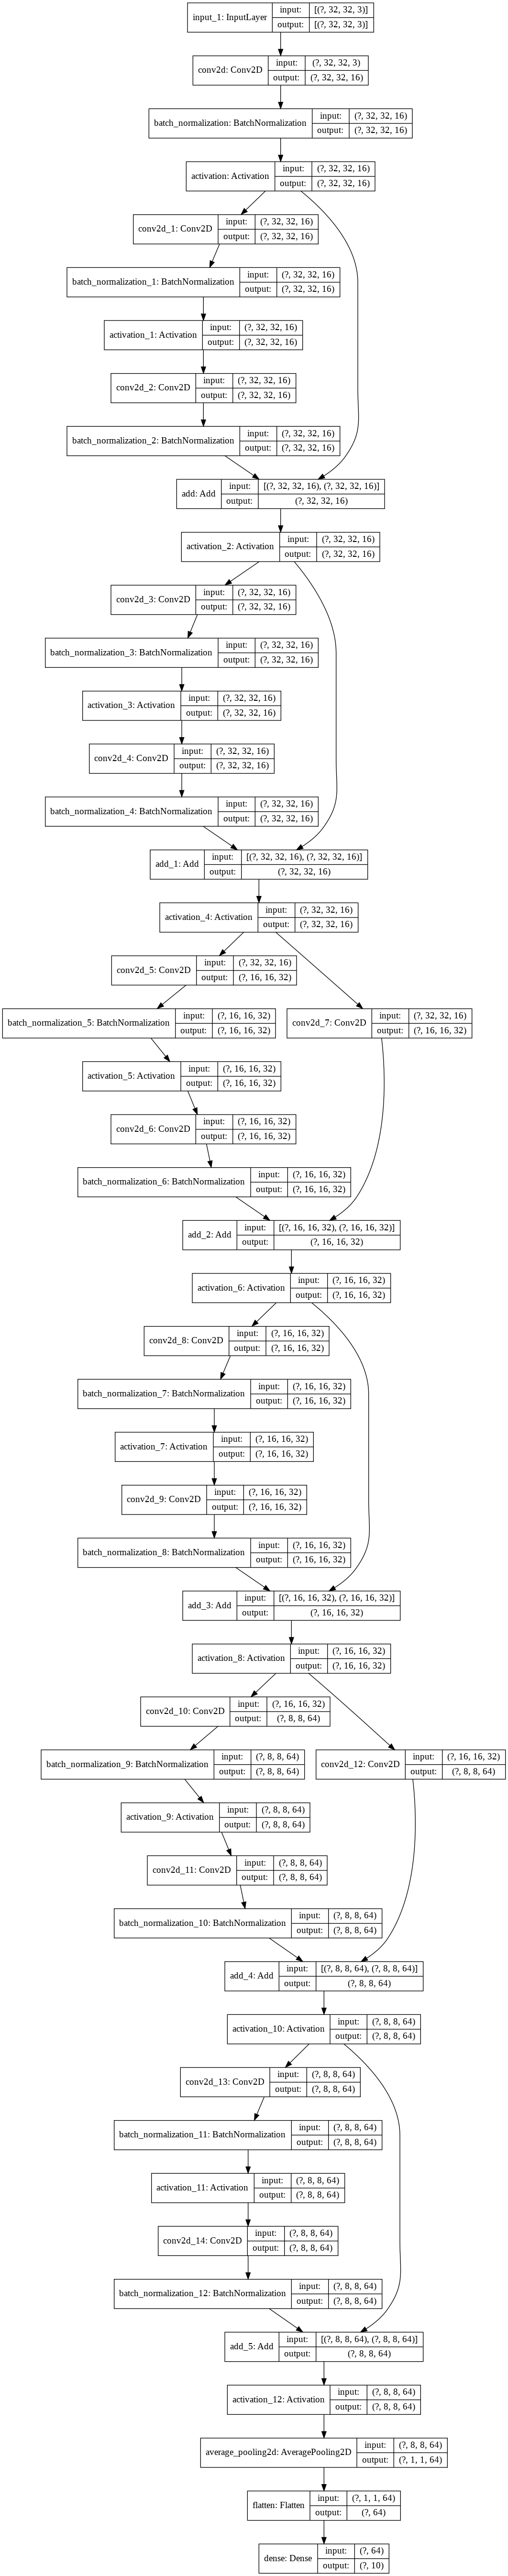

In [12]:
model.summary()
plot_model(model, to_file ='model.png', show_shapes= True)

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [14]:
model.fit(X_train, y_train, epochs =10, batch_size = batch_size)

Epoch 1/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.4703 - accuracy: 0.5090
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0794 - accuracy: 0.6583
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9159 - accuracy: 0.7218
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8119 - accuracy: 0.7624
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7376 - accuracy: 0.7890
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6888 - accuracy: 0.8113
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6397 - accuracy: 0.8289
Epoch 8/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6095 - accuracy: 0.8406
Epoch 9/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.5807 - accuracy: 0.8517
Epoch 10/10
1563/1563 [==============================] - 13s 8ms/step - l

In [15]:
_, acc = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 0 )

In [16]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))


Test accuracy: 74.4%
